### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 08 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 08 декабря, -4 балла после 08:30 15 декабря, -6 баллов после 08:30 22 декабря, -8 баллов после 08:30 29 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

import tqdm

In [425]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = dict()
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        if criterion == "gini":
            self.quality_func = self.gini_impurity
        elif criterion == "classify":
            self.quality_func = self.classify_impurity
        elif criterion == "entropy":
            self.quality_func = self.entropy_impurity
        else:
            raise RuntimeError("Wrong criterition!")

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def classify_impurity(self, y, n):
        tmp = y / n[:, np.newaxis]
        return 1 - np.max(tmp, axis=1)

    def gini_impurity(self, y, n):
        tmp = y / n[:, np.newaxis]
        tmp[np.isnan(tmp)] = 0
        return 1 - np.sum(tmp**2, axis=1)

    def entropy_impurity(self, y, n):
        tmp = y / n[:, np.newaxis]
        tmp_log = tmp
        tmp_log[np.abs(tmp) < 1e-10] = 1
        tmp_log = np.log2(tmp)
        tmp_sum = tmp * tmp_log
        return (-1) * np.sum(tmp_sum, axis=1)

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        # Ваш код здесь
        ind = np.argsort(x)
        x_sort, y_sort = x[ind], y[ind]
        thres, splits = np.unique(x_sort, return_index=True)
        counts = np.bincount(y_sort, minlength=self.num_class)
        left = np.array([np.bincount(y_sort[:k], minlength=self.num_class) for k in splits[:]])
        alles = np.tile(counts, thres.shape[0]).reshape(-1, counts.size)
        alles = alles[1:,:]
        left = left[1:, :]
        right = alles - left
        n_left = np.sum(left, axis=1)
        n_right = np.sum(right, axis=1)
        n = n_left + n_right
        qualities = self.quality_func(alles, n) - (n_left * self.quality_func(left, n_left) + n_right * self.quality_func(right, n_right)) / n
        if(np.isnan(qualities).all()):
            qualities =  np.array([0])
        qualities = qualities[~np.isnan(qualities)]
        max_idx = np.argmax(qualities)
        return qualities[max_idx], thres[max_idx]
    
    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # Ваш код здесь
        n = y.size
        values, counts = np.unique(y, return_counts=True)
        if depth >= self.max_depth or n < self.min_samples_split or values.shape[0] < 2:
            probability = counts / n
            ind = probability.argmax()
            self.tree[node_id] = (self.__class__.LEAF_TYPE, values[ind], probability[ind]) # making current node
        else:
            thres_qualities = np.array([self.__find_threshold(i, y) for i in x.T])
            feature_id = np.argmax(thres_qualities[:, 0])
            threshold = thres_qualities[feature_id, 1]
            x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature_id, threshold)
            if x_left.shape[0] == 0 or x_right.shape[0] == 0:
                probability = counts / n
                ind = probability.argmax()
                self.tree[node_id] = (self.__class__.LEAF_TYPE, values[ind], probability[ind]) # making current node
            else:
                if feature_id not in self.feature_importances_:
                    self.feature_importances_[feature_id] = 0
                self.feature_importances_[feature_id] += thres_qualities[feature_id, 0]
                self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, feature_id, threshold) # making current node
                self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1) # making left node
                self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1) # making right node

    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        # Ваш код здесь
        return self.feature_importances_

In [475]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion="entropy")
clf = DecisionTreeClassifier(min_samples_split=2, criterion="entropy")

In [476]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [477]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [478]:
sklearn_pred = clf.predict(X_test)
my_pred = my_clf.predict(X_test)
print(accuracy_score(y_pred=sklearn_pred, y_true=y_test))
print(accuracy_score(y_pred=my_pred, y_true=y_test))

0.9444444444444444
0.8888888888888888


In [401]:
print(sklearn_pred)
print(my_pred)

[0 2 1 1 0 1 2 2 0 1 2 1 0 0 0 1 0 1]
[0 2 1 1 1 1 2 2 0 1 2 1 0 0 0 1 0 1]


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [487]:
%time clf.fit(X_train, y_train)

Wall time: 1.99 ms


DecisionTreeClassifier(criterion='entropy')

In [488]:
%time my_clf.fit(X_train, y_train)

Wall time: 20 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [357]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

In [265]:
df = pd.read_csv('./data/speed-dating-experiment/Speed Dating Data.csv', encoding='latin1')
df = df.iloc[:, :97]

In [266]:
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)
df = df.drop(['condtn'], axis=1)
df = df.drop(['round'], axis=1)
df = df.drop(['position', 'positin1'], axis=1)
df = df.drop(['order'], axis=1)
df = df.drop(['partner'], axis=1)
df = df.drop(['age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], axis=1)
df = df.dropna(subset=['age'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df = df.drop(['field'], axis=1)
df["field_cd"] = df["field_cd"].map(df.groupby("field_cd").match.sum() / df.groupby("field_cd").size()) # or OneHot, or leave as it is
df = df.drop(['undergra'], axis=1)
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df = df.drop(["mn_sat"], axis=1)
df = df.drop(["tuition"], axis=1)
encoder = OneHotEncoder(sparse=False)
race_list = ['black', 'europ', 'latino', 'asian','other']
tmp = pd.DataFrame(encoder.fit_transform(df.race.values.reshape(-1, 1)), columns=['race_' + i for i in race_list])
df = pd.concat([df, tmp], axis=1)
df = df.drop(['race'], axis=1)
df = df.dropna(subset=['race_black'])
df = df.dropna(subset=['imprelig', 'imprace'])
df = df.drop(['from', 'zipcode'], axis=1)
df = df.drop(['income'], axis=1)
df = df.dropna(subset=['date'])
df = df.drop(['career'], axis=1)
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
df["career_c"] = df["career_c"].map(df.groupby("career_c").match.sum() / df.groupby("career_c").size())
df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)
df = df.drop(['expnum'], axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis=1)
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    df = df.drop(feat, axis=1)

df = df.drop(['wave'], axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'
df_female = df_female.drop(['pid_f'], axis=1)
df_female = df_female.rename(columns={"iid_f" : "pid"})

In [267]:
df_both = pd.merge(df_male, df_female, on="pid")
df_both = df_both.drop(['iid', 'pid'], axis=1)

In [374]:
X, y = df_both.iloc[:,1:].values, df_both.match.values.astype('int')

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [352]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [347]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion='entropy')
clf = DecisionTreeClassifier(min_samples_split=2, criterion='entropy')

In [353]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [354]:
my_predict = my_clf.predict(X_test)
sklearn_predict = clf.predict(X_test)

In [355]:
my_res = (accuracy_score(y_test, my_predict), f1_score(y_test, my_predict, average='macro'))
sklearn_res = (accuracy_score(y_test, sklearn_predict), f1_score(y_test, sklearn_predict, average='macro'))

In [356]:
print(my_res)
print(sklearn_res)

(0.8367346938775511, 0.5337496283080583)
(0.7627551020408163, 0.6022822731091062)


In [412]:
inform_crit = ['gini', 'entropy', 'classify']
cv = StratifiedKFold(n_splits=5, shuffle=True)
crit_res = []
for crit in inform_crit:
    my_clf = MyDecisionTreeClassifier(criterion=crit)
    tmp_res = []
    for train_ind, test_ind in cv.split(X, y):
        X_train, X_test = X[train_ind], X[test_ind]
        y_train, y_test = y[train_ind], y[test_ind]
        my_clf.fit(X_train, y_train)
        my_predict = my_clf.predict(X_test)
        tmp_res.append((accuracy_score(y_test, my_predict), f1_score(y_test, my_predict, average='macro')))
    tmp_res = np.array(tmp_res).mean(axis=0)
    crit_res.append(tmp_res)

In [413]:
crit_res

[array([0.83184519, 0.47982974]),
 array([0.83465359, 0.46778319]),
 array([0.83465359, 0.47799954])]

The best criterion is GINI

In [415]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
depth_res = []
for depth in range(1, 40):
    my_clf = MyDecisionTreeClassifier(criterion='gini', max_depth=depth)
    tmp_res = []
    for train_ind, test_ind in cv.split(X, y):
        X_train, X_test = X[train_ind], X[test_ind]
        y_train, y_test = y[train_ind], y[test_ind]
        my_clf.fit(X_train, y_train)
        my_predict = my_clf.predict(X_test)
        tmp_res.append((accuracy_score(y_test, my_predict), f1_score(y_test, my_predict, average='macro')))
    tmp_res = np.array(tmp_res).mean(axis=0)
    depth_res.append(tmp_res)

In [419]:
np.argmax(np.array(depth_res)[:, 1]) + 1

39

Text(0, 0.5, 'F1 Score')

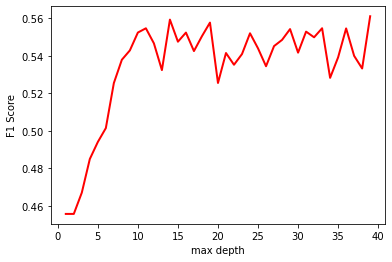

In [418]:
plt.plot(range(1, 40), np.array(depth_res)[:, 1], c='r', lw=2)

plt.xlabel('max depth')
plt.ylabel('F1 Score')

In [420]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
sample_res = []
for sample in range(2, 40):
    my_clf = MyDecisionTreeClassifier(criterion='gini', max_depth=39, min_samples_split=sample)
    tmp_res = []
    for train_ind, test_ind in cv.split(X, y):
        X_train, X_test = X[train_ind], X[test_ind]
        y_train, y_test = y[train_ind], y[test_ind]
        my_clf.fit(X_train, y_train)
        my_predict = my_clf.predict(X_test)
        tmp_res.append((accuracy_score(y_test, my_predict), f1_score(y_test, my_predict, average='macro')))
    tmp_res = np.array(tmp_res).mean(axis=0)
    sample_res.append(tmp_res)

In [423]:
np.argmax(np.array(sample_res)[:, 1]) + 1

24

Text(0, 0.5, 'F1 Score')

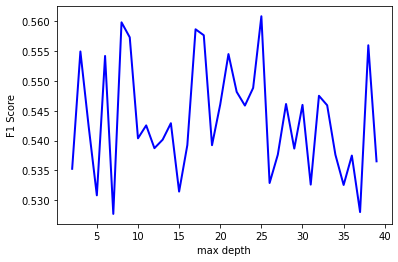

In [424]:
plt.plot(range(2, 40), np.array(sample_res)[:, 1], c='b', lw=2)

plt.xlabel('max depth')
plt.ylabel('F1 Score')

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [426]:
my_clf = MyDecisionTreeClassifier(min_samples_split=24, max_depth=39, criterion='gini')
my_clf.fit(X, y)

In [427]:
feature_importance = my_clf.get_feature_importance()

In [451]:
index = np.argsort(np.array(list(feature_importance.items()))[:,1])

In [473]:
feature_names = df_both.columns.values[1:][index][::-1]
feature_ids = np.array(list(feature_importance.keys()))[index][::-1]
feature_values = np.array(list(feature_importance.values()))[index][::-1]

In [474]:
for k, i, j in zip(feature_names[:10], feature_ids[:10], feature_values[:10]):
    print("Feature name : ", k, " ----> feature id = ", i, " ----> it's score = ", j)

Feature name :  career_c  ----> feature id =  0  ----> it's score =  0.4421437150784013
Feature name :  sinc3_1  ----> feature id =  3  ----> it's score =  0.40626765125328657
Feature name :  date  ----> feature id =  40  ----> it's score =  0.314411660955802
Feature name :  attr2_1_f  ----> feature id =  11  ----> it's score =  0.3056229138124906
Feature name :  intel2_1  ----> feature id =  42  ----> it's score =  0.3013052607421153
Feature name :  amb3_1  ----> feature id =  57  ----> it's score =  0.2734286720096766
Feature name :  field_cd  ----> feature id =  52  ----> it's score =  0.2724946153656076
Feature name :  sinc2_1  ----> feature id =  33  ----> it's score =  0.25426668979335315
Feature name :  intel3_1  ----> feature id =  46  ----> it's score =  0.231455722791782
Feature name :  samerace  ----> feature id =  12  ----> it's score =  0.2215585658019047


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



Хотелось бы побольше информации о методах ускорения работы классификаторов!